INSTITUTO FEDERAL DE EDUCAÇÃO, CIÊNCIA E TECNOLOGIA DE SANTA CATARINA \
CAMPUS FLORIANÓPOLIS \
DEPARTAMENTO ACADÊMICO DE ELETRÔNICA \
ENGENHARIA ELETRÔNICA

Estudantes: Alejo Perdomo Milar e João Mário Carnieletto Izoton Lago.


# Atividade: Filtros em Imagens

In [48]:
%pip install -q numpy matplotlib scikit-image scipy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Trabalhando com imagens pré-gravadas no computador

### Filtros passa-baixas

1. Vimos que para filtrar uma imagem, é necessário definir um *kernel*, que nada mais é que a resposta ao impulso do filtro. Considere a imagem [1]. Defina filtros passa-baixas (a) 3x3 e (b) 9x9. Você pode gerar manualmente a matriz (como no exemplo _Blur_ de [2]) ou usar um dos elementos estruturantes (*square*, *disk*, etc.) do módulo *morphology* do Skimage [3]. Filtre a imagem. A imagem é melhorada com esses filtros? Mostre os resultados.

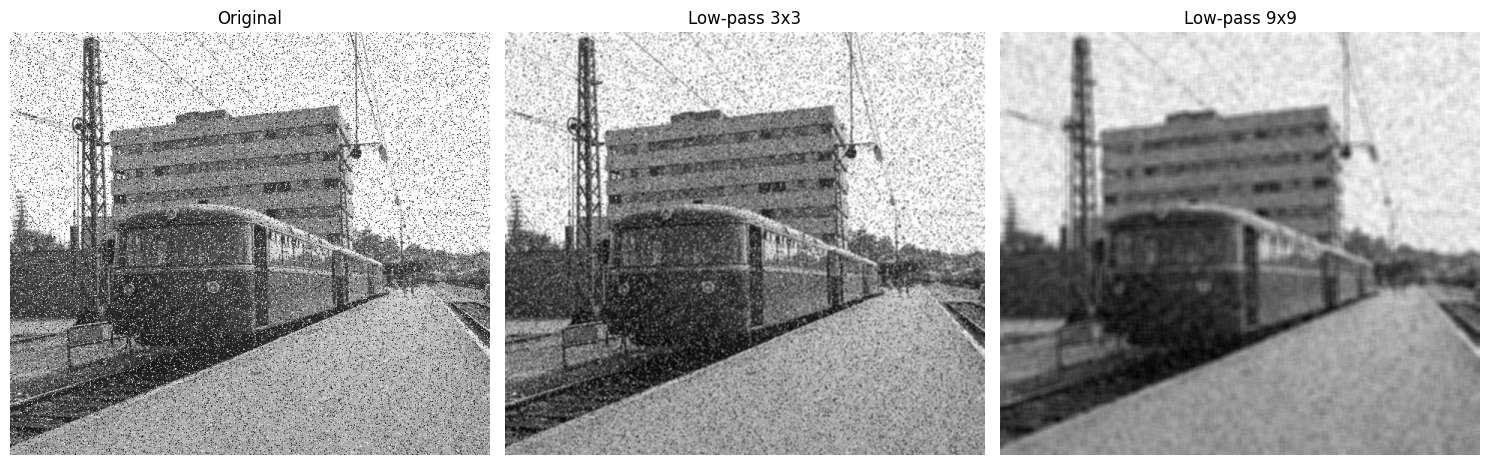

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.ndimage import convolve
from skimage.morphology import disk

image = io.imread("assets/hw3_train.jpg")

kernel_3x3 = np.ones((3,3)) / 9
kernel_9x9 = np.ones((9,9)) / 81

filtered_3x3 = convolve(image, kernel_3x3)
filtered_9x9 = convolve(image, kernel_9x9)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(filtered_3x3, cmap='gray')
axes[1].set_title('Low-pass 3x3')
axes[1].axis('off')

axes[2].imshow(filtered_9x9, cmap='gray')
axes[2].set_title('Low-pass 9x9')
axes[2].axis('off')

plt.tight_layout()
plt.show()


O filtro 3x3 suavizou levemente o ruído granular, preservando os contornos e mantendo contraste aceitável porém ainda possui a existencia do ruido; assim, há leve melhora visual sem perda de detalhes. Já o kernel 9x9 diluiu as altas frequências, borrando as bordas e apagando texturas finas, o que compromete a imagem apesar de reduzir ruídos. Portanto, o passa-baixas compacto representa um ganho melhor para essa imagem, porém ainda não apresenta uma perforance perfeita.

2. Filtre a mesma imagem [1] com filtro de mediana [4]. A imagem é melhorada? Qual a influência do tamanho do filtro e do formato do elemento estruturante? O filtro de mediana é linear? Mostre os resultados.

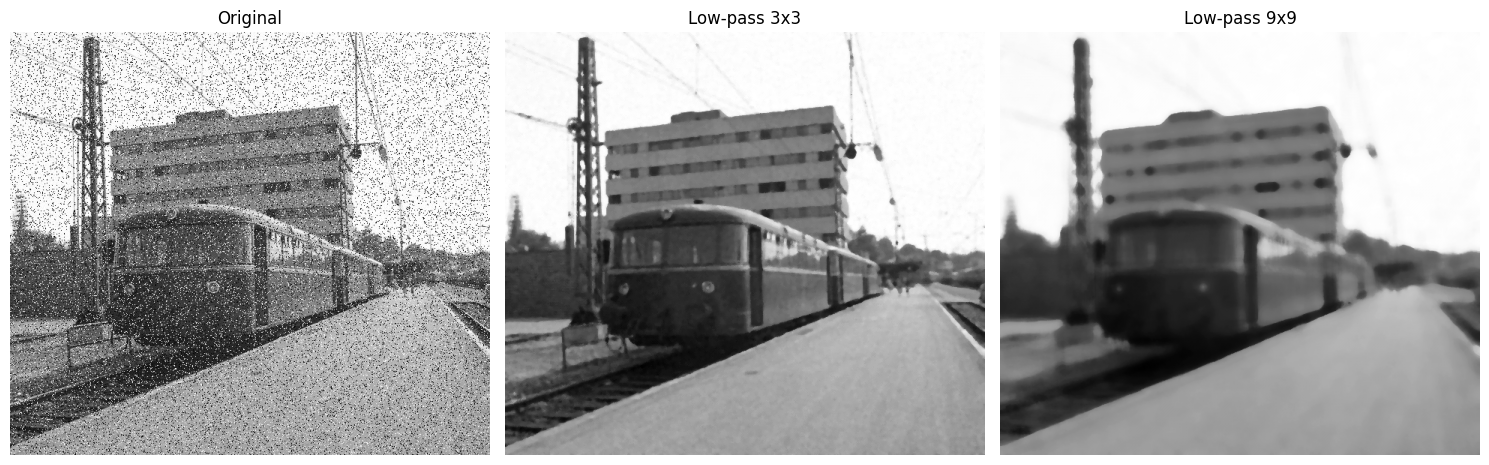

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.ndimage import convolve
from skimage.morphology import disk
from skimage.filters import median

image = io.imread("assets/hw3_train.jpg")

kernel_3x3 = disk(3) / 9
kernel_9x9 = disk(9) / 81

# Filtering using median filter
filtered_3x3 = median(image, kernel_3x3)
filtered_9x9 = median(image, kernel_9x9)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(filtered_3x3, cmap='gray')
axes[1].set_title('Low-pass 3x3')
axes[1].axis('off')

axes[2].imshow(filtered_9x9, cmap='gray')
axes[2].set_title('Low-pass 9x9')
axes[2].axis('off')

plt.tight_layout()
plt.show()


A mediana com janela pequena removeu o ruído impulsivo sem borrar contornos, enquanto a janela maior alisou manchas residuais às custas de texturas e de uma aparência artificial. O formato do elemento estruturante determina quais direções recebem maior ponderação (um disco mantém isotropia, um quadrado ou cruz tende a preservar eixos específicos) e impacta o quanto bordas inclinadas são erodidas. Trata-se de um filtro não linear, pois substitui cada pixel pela ordem estatística local em vez de aplicar uma combinação linear dos valores.

### Filtros passa-altas

3. Considere a imagem [5]. Procure melhorá-la (aguçar os contornos) usando um filtro linear. Você pode usar um filtro passa-altas (como no exemplo _Sharpening_ de [2]) ou a máscara *unsharp_mask* de `skimage.filters` [6]. Apresente os resultados.

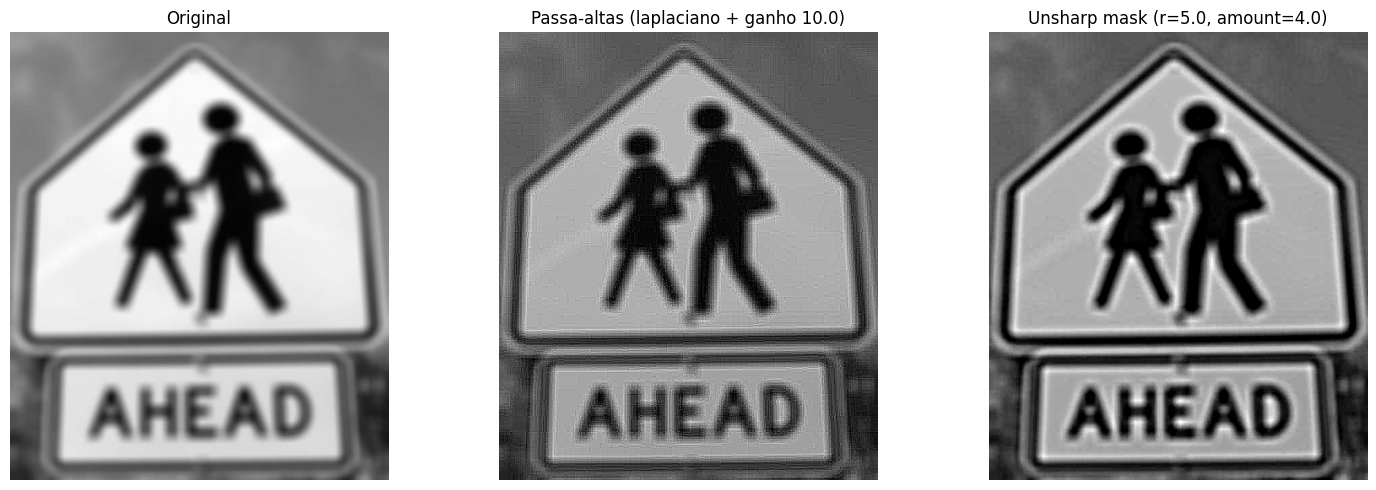

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.filters import unsharp_mask
from scipy.ndimage import convolve

HIGH_PASS_KERNEL = np.array([[0, -1, 0],
                             [-1, 4, -1],
                             [0, -1, 0]])
HIGH_PASS_GAIN = 10.0
UNSHARP_RADIUS = 5.0
UNSHARP_AMOUNT = 4.0

image = img_as_float(io.imread('assets/hw3_road_sign_school_blurry.jpg'))


def apply_laplacian_boost(arr):
    def _process(channel):
        response = convolve(channel, HIGH_PASS_KERNEL, mode='reflect')
        return np.clip(channel + HIGH_PASS_GAIN * response, 0, 1)

    if arr.ndim == 2:
        return _process(arr)

    boosted = np.empty_like(arr)
    for idx in range(arr.shape[2]):
        boosted[..., idx] = _process(arr[..., idx])
    return boosted


laplacian_sharpened = apply_laplacian_boost(image)
unsharp = np.clip(
    unsharp_mask(image, radius=UNSHARP_RADIUS, amount=UNSHARP_AMOUNT),
    0,
    1,
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, title in zip(
    axes,
    [image, laplacian_sharpened, unsharp],
    [
        'Original',
        f'Passa-altas (laplaciano + ganho {HIGH_PASS_GAIN})',
        f'Unsharp mask (r={UNSHARP_RADIUS}, amount={UNSHARP_AMOUNT})'
    ],
):
    cmap = 'gray' if img.ndim == 2 else None
    ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


O `HIGH_PASS_KERNEL` laplaciano reforçado com ganho 10.0 destaca as altas frequências, deixando os contornos da placa levemente mais contrastados. A máscara unsharp com raio 5.0 e ganho 4.0 entrega um resultado parecido, mas preserva um pouco mais os tons médios e evidencia mais os contornos.


4. Agora, a partir da imagem `gray`, use as funções `cv.filter2D` e `cv.mediamBlur` [7] para melhorar a imagem capturada. Apresente o código, imagens resultantes e comente.


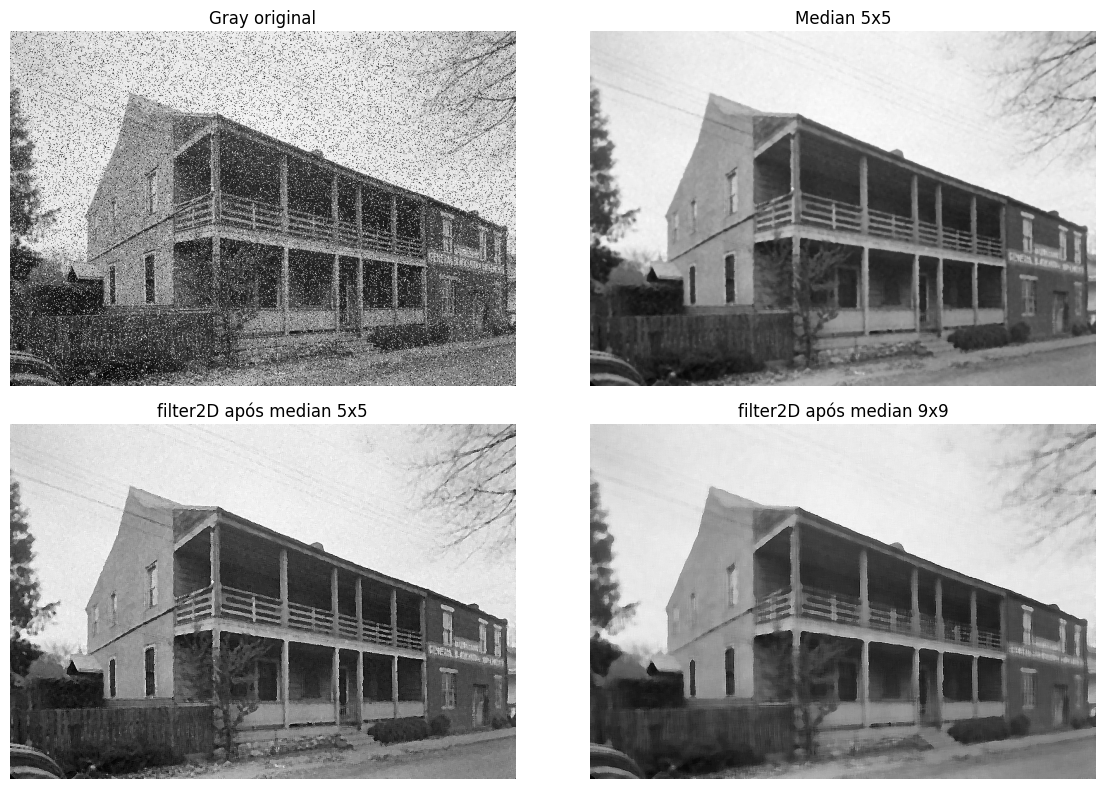

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

gray = cv2.imread('assets/hw3_building.jpg', cv2.IMREAD_GRAYSCALE)
median_5 = cv2.medianBlur(gray, 5)
median_9 = cv2.medianBlur(gray, 9)

sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=np.float32)

sharp_5 = cv2.filter2D(median_5, -1, sharpen_kernel)
sharp_9 = cv2.filter2D(median_9, -1, sharpen_kernel)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].imshow(gray, cmap='gray')
axes[0, 0].set_title('Gray original')
axes[0, 0].axis('off')

axes[0, 1].imshow(median_5, cmap='gray')
axes[0, 1].set_title('Median 5x5')
axes[0, 1].axis('off')

axes[1, 0].imshow(sharp_5, cmap='gray')
axes[1, 0].set_title('filter2D após median 5x5')
axes[1, 0].axis('off')

axes[1, 1].imshow(sharp_9, cmap='gray')
axes[1, 1].set_title('filter2D após median 9x9')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


Primeiro suaviza o ruído impulsivo com `medianBlur` e então aplica-se o kernel de nitidez via `filter2D`. O kernel 5x5 preservou mais detalhe, enquanto o 9x9 removeu ruídos maiores antes do realce, deixando contornos mais uniformes em troca de leve perda de textura.

A melhor imagem ficou filter2D após median 5x5.

## Detecção de bordas

5. Usando um kernel do tipo Sobel ou Canny, identifique as bordas da folha na imagem [8]. Mostre o resultado. Depois, aplique os mesmos parâmetros para a imagem [9]. As bordas são detectadas corretamente? É necessário ajustar os parâmetros?

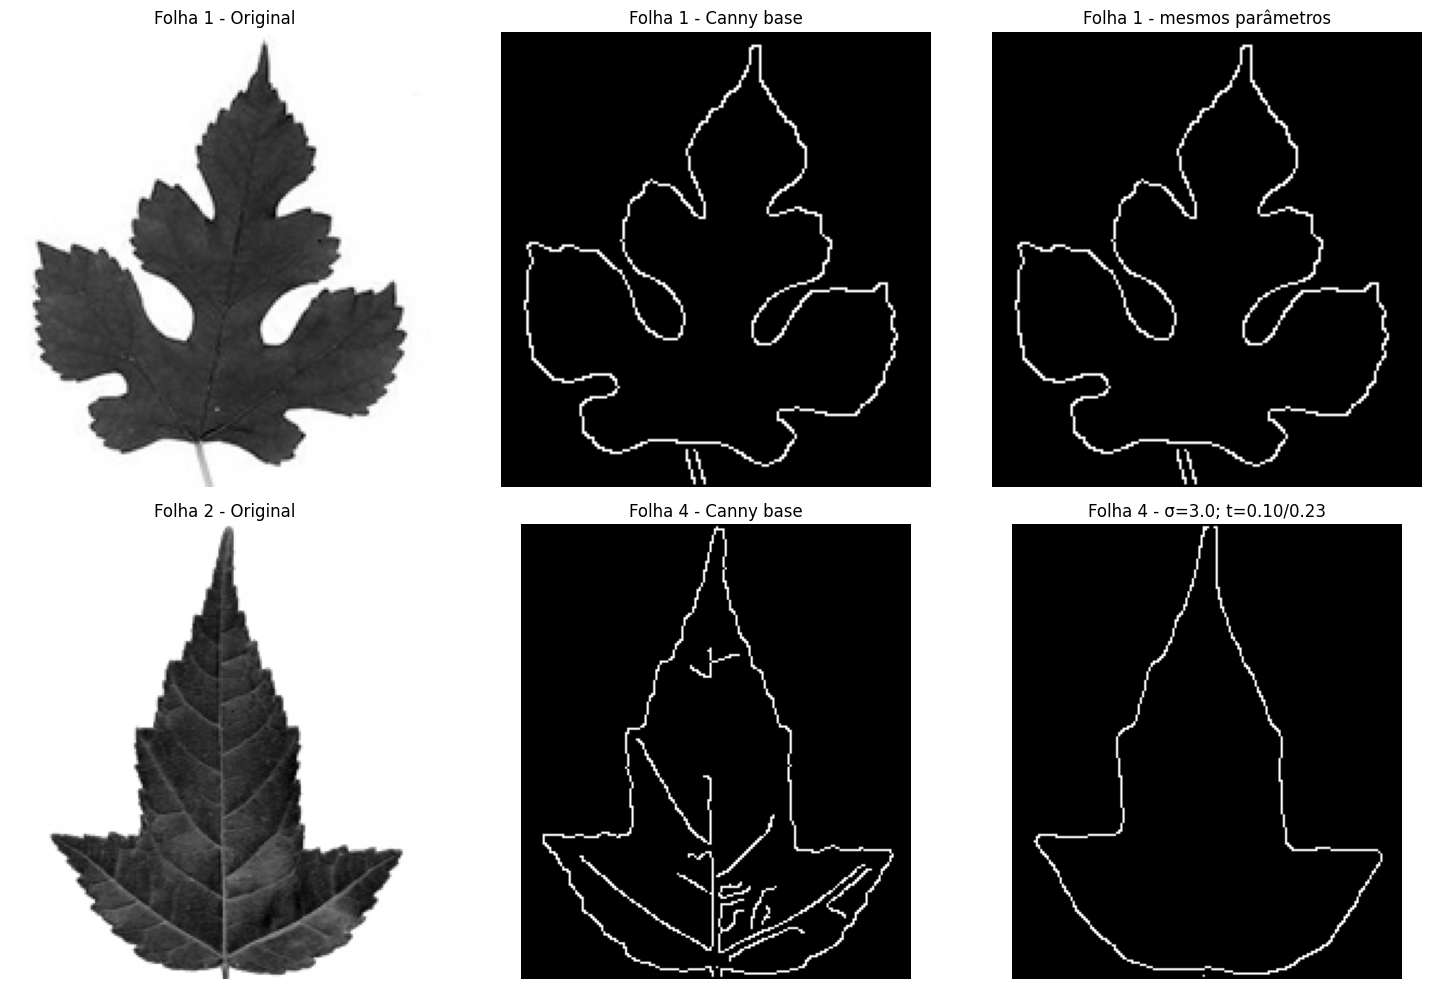

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_float, color
from skimage.feature import canny

paths = ['assets/hw3_leaf_training_1.jpg', 'assets/hw3_leaf_training_4.jpg']
images = [img_as_float(io.imread(p)) for p in paths]
grays = [color.rgb2gray(img) for img in images]

edges_params = {'sigma': 1.5, 'low_threshold': 0.08, 'high_threshold': 0.2}
edges_leaf1 = canny(grays[0], **edges_params)
edges_leaf2_same = canny(grays[1], **edges_params)
edges_leaf2_tuned = canny(grays[1], sigma=3.0, low_threshold=0.10, high_threshold=0.23)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

titles = ['Original', 'Canny base', 'Canny ajustado']
for row in range(2):
    axes[row, 0].imshow(grays[row], cmap='gray')
    axes[row, 0].set_title(f'Folha {row+1} - {titles[0]}')
    axes[row, 0].axis('off')

axes[0, 1].imshow(edges_leaf1, cmap='gray')
axes[0, 1].set_title('Folha 1 - Canny base')
axes[0, 1].axis('off')
axes[0, 2].imshow(edges_leaf1, cmap='gray')
axes[0, 2].set_title('Folha 1 - mesmos parâmetros')
axes[0, 2].axis('off')

axes[1, 1].imshow(edges_leaf2_same, cmap='gray')
axes[1, 1].set_title('Folha 4 - Canny base')
axes[1, 1].axis('off')
axes[1, 2].imshow(edges_leaf2_tuned, cmap='gray')
axes[1, 2].set_title('Folha 4 - σ=3.0; t=0.10/0.23')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


O primeiro conjunto respondeu bem a `sigma=1.5` e limiares 0.08/0.2, destacando toda a borda principal. Na folha 4 foi necessário aumentar o sigma e os limiares para equilibrar o contraste, a detecção da borda principal ficou contínua e boa porém é perdido um pouco de textura, aparentando um efeito de um passa baixa aplicado.

## Referências

[1] hw3_train.jpg da pasta **hw3_data** (obtido de http://web.stanford.edu/class/ee368/Handouts/Homeworks/HW3/hw3_data.zip)

[2] https://www.codingame.com/playgrounds/2524/basic-image-manipulation/filtering

[3] https://scikit-image.org/docs/dev/api/skimage.morphology.html

[4] https://scikit-image.org/docs/dev/auto_examples/applications/plot_rank_filters.html#noise-removal

[5] hw3_road_sign_school_blurry.jpg, da pasta **hw3_data** (obtido de http://web.stanford.edu/class/ee368/Handouts/Homeworks/HW3/hw3_data.zip)

[6] https://scikit-image.org/docs/dev/auto_examples/filters/plot_unsharp_mask.html

[7] https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

[8] hw3_leaf_training_1.jpg, da pasta **hw3_data** (obtido de http://web.stanford.edu/class/ee368/Handouts/Homeworks/HW3/hw3_data.zip)

[9] hw3_leaf_training_4.jpg, da pasta **hw3_data** (obtido de http://web.stanford.edu/class/ee368/Handouts/Homeworks/HW3/hw3_data.zip)

## Bibliografia

https://scikit-image.org/docs/dev/auto_examples/applications/plot_rank_filters.html#image-smoothing


https://www.mathworks.com/help/images/what-is-image-filtering-in-the-spatial-domain.html

https://www.mathworks.com/examples/image/mw/images-ex48835658-detect-edges-in-images

https://www.mathworks.com/examples/image/mw/images-ex80028725-trace-boundaries-of-objects-in-images

https://www.mathworks.com/help/images/ref/imfindcircles.html#examples

https://www.mathworks.com/examples/image/community/18507-missing-planes